In [1]:
from datetime import datetime
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['figure.facecolor'] = 'w'

In [2]:
def date_parser(x):
    if str.lower(x) == 'unknown':
        return None
    return datetime.strptime(x, '%Y-%m-%dT%H:%M:%S')

df = pd.read_csv('../data/fullsample.csv',
                 parse_dates=['BEGIN', 'END'],
                 date_parser=date_parser)


In [3]:
df = df.rename(columns=str.lower)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7395885 entries, 0 to 7395884
Data columns (total 12 columns):
 #   Column     Dtype         
---  ------     -----         
 0   jobid      object        
 1   state      object        
 2   begin      datetime64[ns]
 3   end        datetime64[ns]
 4   reqmem     object        
 5   usedmem    object        
 6   reqtime    object        
 7   usedtime   object        
 8   nodes      int64         
 9   cpus       int64         
 10  partition  object        
 11  exitcode   object        
dtypes: datetime64[ns](2), int64(2), object(8)
memory usage: 677.1+ MB


In [6]:
# add date and hour of day column
df['date_end'] = df['end'].dt.date
df['week_end'] = df['end'].dt.week
df['month_end'] = df['end'].dt.month
df['hour_of_day_end'] = df['end'].dt.hour

df.info()

<ipython-input-6-33c466c276fd>:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['week_end'] = df['end'].dt.week


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7395885 entries, 0 to 7395884
Data columns (total 16 columns):
 #   Column           Dtype         
---  ------           -----         
 0   jobid            object        
 1   state            object        
 2   begin            datetime64[ns]
 3   end              datetime64[ns]
 4   reqmem           object        
 5   usedmem          object        
 6   reqtime          object        
 7   usedtime         object        
 8   nodes            int64         
 9   cpus             int64         
 10  partition        object        
 11  exitcode         object        
 12  date_end         object        
 13  week_end         float64       
 14  month_end        float64       
 15  hour_of_day_end  float64       
dtypes: datetime64[ns](2), float64(3), int64(2), object(9)
memory usage: 902.8+ MB


In [7]:
# count values per day per hour

jobs_ended = df\
    .value_counts(subset=['date_end',
                          'month_end',
                          'week_end',
                          'hour_of_day_end'])\
    .reset_index()\
    .set_index(['date_end', 'week_end', 'month_end','hour_of_day_end'])\
    .rename(columns={0:'jobs_ended_per_hour'})


,jobs_ended_per_hour
hour_of_day_end,
11.0,375413
15.0,396458
16.0,415430
17.0,417068
18.0,387521


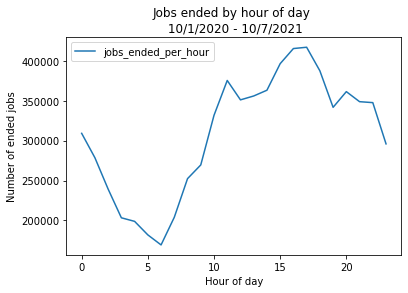

In [25]:
jobs_ended_hour = jobs_ended\
    .groupby('hour_of_day_end')\
    .agg('sum')

jobs_ended_hour.plot(kind='line',
      title='Jobs ended by hour of day \n 10/1/2020 - 10/7/2021',
      xlabel='Hour of day',
      ylabel='Number of ended jobs')


In [35]:
top_5_busiest_hours = jobs_ended_hour.nlargest(columns='jobs_ended_per_hour', n=5).sort_values(by='hour_of_day_end')
bottom_5_busiest_hours = jobs_ended_hour.nsmallest(columns='jobs_ended_per_hour', n=5).sort_values(by='hour_of_day_end')

print(f'The top 5 busiest hours of the day were: {top_5_busiest_hours.index.values.astype(int)}')
print(f'The least busiest hours of the day were: {bottom_5_busiest_hours.index.values.astype(int)}')


The top 5 busiest hours of the day were: [11 15 16 17 18]
The least busiest hours of the day were: [3 4 5 6 7]


<AxesSubplot:title={'center':'Jobs ended by week \n 10/1/2020 - 10/7/2021'}, xlabel='Week', ylabel='Number of jobs ended'>

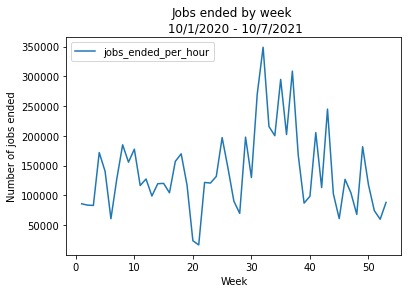

In [50]:
jobs_ended_week = jobs_ended\
    .groupby('week_end')\
    .agg('sum')

jobs_ended_week.plot(kind='line',
          title='Jobs ended by week \n 10/1/2020 - 10/7/2021',
          xlabel='Week',
          ylabel='Number of jobs ended')

In [39]:
top_5_busiest_weeks = jobs_ended_week.nlargest(columns='jobs_ended_per_hour', n=5).sort_values(by='week_end')
bottom_5_busiest_weeks = jobs_ended_week.nsmallest(columns='jobs_ended_per_hour', n=5).sort_values(by='week_end')

print(f'The top 5 busiest weeks were: {top_5_busiest_weeks.index.values.astype(int)}')
print(f'The least busiest weeks were: {bottom_5_busiest_weeks.index.values.astype(int)}')

The top 5 busiest weeks were: [31 32 35 37 43]
The least busiest weeks were: [ 6 20 21 45 52]


<AxesSubplot:title={'center':'Jobs ended by month \n 10/1/2020 - 10/7/2021'}, xlabel='Month', ylabel='Number of jobs ended'>

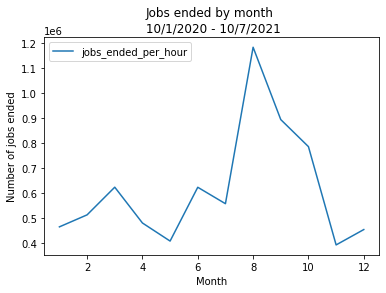

In [49]:
jobs_ended_month = jobs_ended\
    .groupby('month_end')\
    .agg('sum')

jobs_ended_month.plot(kind='line',
          title='Jobs ended by month \n 10/1/2020 - 10/7/2021',
          xlabel='Month',
          ylabel='Number of jobs ended')

In [42]:
top_5_busiest_months = jobs_ended_month.nlargest(columns='jobs_ended_per_hour', n=5).sort_values(by='month_end')
bottom_5_busiest_months = jobs_ended_month.nsmallest(columns='jobs_ended_per_hour', n=5).sort_values(by='month_end')

print(f'The top 5 busiest months were: {top_5_busiest_months.index.values.astype(int)}')
print(f'The least busiest months were: {bottom_5_busiest_months.index.values.astype(int)}')

The top 5 busiest months were: [ 3  6  8  9 10]
The least busiest months were: [ 1  4  5 11 12]


In [45]:
jobs_ended.describe()

,jobs_ended_per_hour
count,8922.000000
mean,828.876261
std,1188.058799
min,2.000000
25%,252.000000
50%,488.000000
75%,909.000000
max,13346.000000
